ab_data shape: (294480, 5)
   user_id timestamp      group landing_page  converted
0   851104   11:48.6    control     old_page          0
1   804228   01:45.2    control     old_page          0
2   661590   55:06.2  treatment     new_page          0
3   853541   28:03.1  treatment     new_page          0
4   864975   52:26.2    control     old_page          1
countries shape: (290586, 2)
   user_id country
0   834778      UK
1   928468      US
2   822059      UK
3   711597      UK
4   710616      UK


/tmp/ipython-input-1212307174.py:52: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")


Found 633 duplicated user_id rows; keeping earliest per user.
Removing 1259 group/page mismatches.
Merged countries.

--- Conversion Summary ---
Control CR:   12.1536%
Treatment CR: 11.7555%
Lift:         -3.28%

Z-test results:
z-stat: -2.084, p-value: 0.03713

Bootstrap 95% CI: (-0.7826%, -0.0383%)


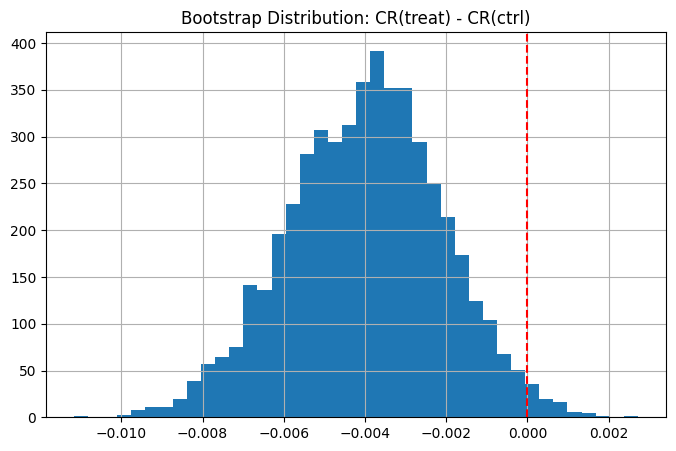

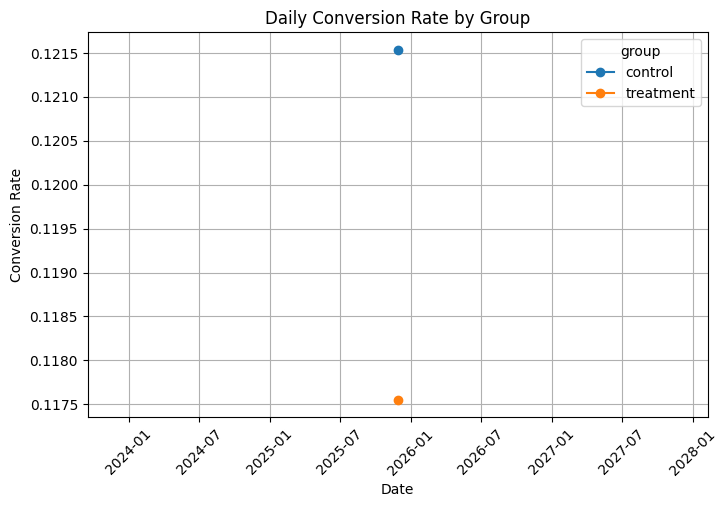

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               115376
Model:                          Logit   Df Residuals:                   115370
Method:                           MLE   Df Model:                            5
Date:                Fri, 28 Nov 2025   Pseudo R-squ.:               0.0001121
Time:                        03:24:07   Log-Likelihood:                -42224.
converged:                       True   LL-Null:                       -42228.
Covariance Type:            nonrobust   LLR p-value:                   0.09184
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -2.0205      0.058    -34.697      0.000      -2.135      -1.906
C(country_top)[T.UK]              0.0230      0.064      0.361      0.718 

In [ ]:

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import statsmodels.formula.api as smf

pd.set_option("display.max_columns", 100)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

AB_PATH = "/content/ab_data.csv"
COUNTRY_PATH = "/content/countries.csv"


df = pd.read_csv(AB_PATH)
print("ab_data shape:", df.shape)
print(df.head())

if os.path.exists(COUNTRY_PATH):
    countries = pd.read_csv(COUNTRY_PATH)
    print("countries shape:", countries.shape)
    print(countries.head())
else:
    countries = None
    print("WARNING: countries.csv not found. Country-level modeling will be skipped.")


expected_cols = {"user_id", "timestamp", "group", "landing_page", "converted"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Required columns missing in ab_data.csv: {missing}")

df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"])

df["converted"] = pd.to_numeric(df["converted"], errors="coerce").fillna(0).astype(int)


df = df.drop_duplicates()
dup_users = df["user_id"].duplicated().sum()
if dup_users > 0:
    print(f"Found {dup_users} duplicated user_id rows; keeping earliest per user.")
    df = df.sort_values("timestamp").drop_duplicates(subset=["user_id"], keep="first")

mismatch = ~(
    ((df["group"] == "treatment") & (df["landing_page"] == "new_page")) |
    ((df["group"] == "control") & (df["landing_page"] == "old_page"))
)
if mismatch.sum() > 0:
    print(f"Removing {mismatch.sum()} group/page mismatches.")
    df = df.loc[~mismatch].copy()


if countries is not None:
    cntry_col = None
    for c in ["country", "Country", "COUNTRY"]:
        if c in countries.columns:
            cntry_col = c
            break
    if cntry_col is None and countries.shape[1] >= 2:
        cntry_col = countries.columns[1]
    if "user_id" in countries.columns and cntry_col:
        countries = countries[["user_id", cntry_col]].rename(columns={cntry_col: "country"})
        df = df.merge(countries, on="user_id", how="left")
        print("Merged countries.")
    else:
        countries = None


n_total = len(df)
n_treat = (df["group"] == "treatment").sum()
n_ctrl  = (df["group"] == "control").sum()

conv_treat = df.loc[df["group"]=="treatment","converted"]
conv_ctrl  = df.loc[df["group"]=="control","converted"]

cr_treat = conv_treat.mean()
cr_ctrl  = conv_ctrl.mean()
lift = (cr_treat / cr_ctrl - 1.0)

print("\n--- Conversion Summary ---")
print(f"Control CR:   {cr_ctrl:.4%}")
print(f"Treatment CR: {cr_treat:.4%}")
print(f"Lift:         {lift:.2%}")


count = np.array([conv_treat.sum(), conv_ctrl.sum()])
nobs  = np.array([n_treat, n_ctrl])
z_stat, pval = proportions_ztest(count, nobs)
print("\nZ-test results:")
print(f"z-stat: {z_stat:.3f}, p-value: {pval:.4g}")


rng = np.random.default_rng(42)
B = 5000
boot_diffs = []
for _ in range(B):
    s_t = rng.choice(conv_treat, size=len(conv_treat), replace=True).mean()
    s_c = rng.choice(conv_ctrl, size=len(conv_ctrl), replace=True).mean()
    boot_diffs.append(s_t - s_c)
ci_boot = np.percentile(boot_diffs, [2.5, 97.5])
print(f"\nBootstrap 95% CI: ({ci_boot[0]:.4%}, {ci_boot[1]:.4%})")

plt.hist(boot_diffs, bins=40)
plt.axvline(0, color="red", linestyle="--")
plt.title("Bootstrap Distribution: CR(treat) - CR(ctrl)")
plt.show()


df["date"] = df["timestamp"].dt.date
daily = df.groupby(["date","group"])["converted"].mean().unstack()
daily.plot(marker="o")
plt.title("Daily Conversion Rate by Group")
plt.xlabel("Date")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.show()


if countries is not None and "country" in df.columns:
    df_lr = df.dropna(subset=["country"]).copy()
    df_lr["is_treat"] = (df_lr["group"] == "treatment").astype(int)
    top_c = df_lr["country"].value_counts().head(5).index.tolist()
    df_lr["country_top"] = df_lr["country"].where(df_lr["country"].isin(top_c), "OTHER")
    model = smf.logit("converted ~ is_treat * C(country_top)", data=df_lr).fit(disp=False)
    print(model.summary())

a0, b0 = 1, 1
a_t = a0 + conv_treat.sum()
b_t = b0 + (n_treat - conv_treat.sum())
a_c = a0 + conv_ctrl.sum()
b_c = b0 + (n_ctrl - conv_ctrl.sum())
S = 100000
theta_t = np.random.beta(a_t, b_t, size=S)
theta_c = np.random.beta(a_c, b_c, size=S)
post_diff = theta_t - theta_c
prob_t_better = (post_diff > 0).mean()
ci_bayes = np.percentile(post_diff, [2.5, 97.5])

print(f"\nBayesian: P(Treatment > Control) = {prob_t_better:.3f}")
print(f"95% credible interval = ({ci_bayes[0]:.4%}, {ci_bayes[1]:.4%})")


ab_data shape: (294480, 5)
   user_id timestamp      group landing_page  converted
0   851104   11:48.6    control     old_page          0
1   804228   01:45.2    control     old_page          0
2   661590   55:06.2  treatment     new_page          0
3   853541   28:03.1  treatment     new_page          0
4   864975   52:26.2    control     old_page          1
countries shape: (290586, 2)

--- Conversion Summary ---
Control CR:   12.0239%
Treatment CR: 11.8732%
Lift:         -1.25%

Z-test results:
z-stat: -1.248, p-value: 0.21200

Bootstrap 95% CI: (-0.3842%, 0.0780%)


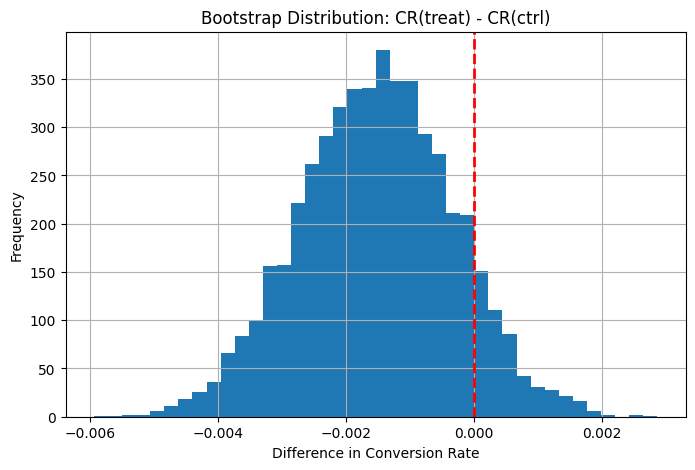

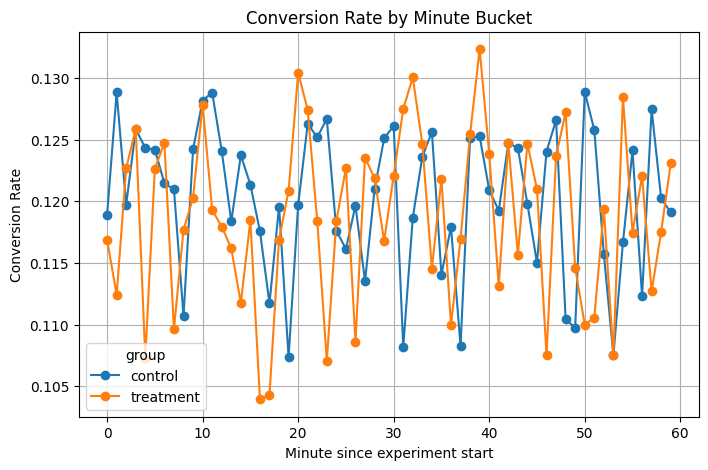


Bayesian: P(Treatment > Control) = 0.107
95% credible interval = (-0.3876%, 0.0858%)

================= SUMMARY =================
Control CR = 12.0239%
Treatment CR = 11.8732%
Lift = -1.25%
Z-test p = 0.21200
Bootstrap 95% CI = (-0.3842%, 0.0780%)
P(Treatment > Control) = 0.107


In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.formula.api as smf

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

AB_PATH = "/content/ab_data.csv"
COUNTRY_PATH = "/content/countries.csv"


df = pd.read_csv(AB_PATH)
print("ab_data shape:", df.shape)
print(df.head())

# 국가 데이터 로드
try:
    countries = pd.read_csv(COUNTRY_PATH)
    print("countries shape:", countries.shape)
except:
    countries = None
    print("countries.csv not found")

def looks_like_mmss(series: pd.Series) -> bool:
    s = series.astype(str)
    return s.str.match(r"^\d{1,2}:\d{2}(\.\d+)?$").mean() > 0.9

if looks_like_mmss(df["timestamp"]):
    # 분:초(.f) 형식 → timedelta 로 변환
    df["elapsed"] = pd.to_timedelta("00:" + df["timestamp"].astype(str))
    df["timestamp"] = pd.Timestamp("2025-01-01") + df["elapsed"]
    df["minute_bucket"] = (df["elapsed"].dt.total_seconds() // 60).astype(int)
else:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"])


df["converted"] = pd.to_numeric(df["converted"], errors="coerce").fillna(0).astype(int)

# 완전 중복 제거
df = df.drop_duplicates()

# 동일 user_id 중복 제거 (최초 1회만 유지)
df = df.sort_values("timestamp").drop_duplicates(subset=["user_id"], keep="first")

# 그룹–페이지 불일치 제거
mismatch = ~(
    ((df["group"] == "treatment") & (df["landing_page"] == "new_page")) |
    ((df["group"] == "control") & (df["landing_page"] == "old_page"))
)
df = df.loc[~mismatch].copy()


if countries is not None:
    cntry_col = None
    for c in ["country", "Country", "COUNTRY"]:
        if c in countries.columns:
            cntry_col = c
            break
    if cntry_col is None and countries.shape[1] >= 2:
        cntry_col = countries.columns[1]
    if "user_id" in countries.columns and cntry_col:
        countries = countries[["user_id", cntry_col]].rename(columns={cntry_col: "country"})
        df = df.merge(countries, on="user_id", how="left")


conv_ctrl = df.loc[df["group"] == "control", "converted"]
conv_treat = df.loc[df["group"] == "treatment", "converted"]

cr_ctrl = conv_ctrl.mean()
cr_treat = conv_treat.mean()
lift = (cr_treat / cr_ctrl - 1) * 100

print("\n--- Conversion Summary ---")
print(f"Control CR:   {cr_ctrl:.4%}")
print(f"Treatment CR: {cr_treat:.4%}")
print(f"Lift:         {lift:.2f}%")

# 두 비율의 차이에 대한 z-test
count = np.array([conv_treat.sum(), conv_ctrl.sum()])
nobs = np.array([len(conv_treat), len(conv_ctrl)])
z_stat, p_val = proportions_ztest(count, nobs)
print("\nZ-test results:")
print(f"z-stat: {z_stat:.3f}, p-value: {p_val:.5f}")


rng = np.random.default_rng(42)
B = 5000
boot_diffs = []
for _ in range(B):
    s_t = rng.choice(conv_treat, size=len(conv_treat), replace=True).mean()
    s_c = rng.choice(conv_ctrl, size=len(conv_ctrl), replace=True).mean()
    boot_diffs.append(s_t - s_c)
boot_diffs = np.array(boot_diffs)

ci_boot = np.percentile(boot_diffs, [2.5, 97.5])
print(f"\nBootstrap 95% CI: ({ci_boot[0]:.4%}, {ci_boot[1]:.4%})")

plt.hist(boot_diffs, bins=40)
plt.axvline(0, color='r', linestyle='--', linewidth=2)
plt.title("Bootstrap Distribution: CR(treat) - CR(ctrl)")
plt.xlabel("Difference in Conversion Rate")
plt.ylabel("Frequency")
plt.show()

if "minute_bucket" in df.columns:
    minute_curve = (
        df.groupby(["minute_bucket", "group"])["converted"]
          .mean().unstack().sort_index()
    )
    minute_curve.plot(marker="o")
    plt.title("Conversion Rate by Minute Bucket")
    plt.xlabel("Minute since experiment start")
    plt.ylabel("Conversion Rate")
    plt.legend(title="group")
    plt.show()
else:
    df["date"] = df["timestamp"].dt.date
    daily = df.groupby(["date", "group"])["converted"].mean().unstack()
    daily.plot(marker="o")
    plt.title("Daily Conversion Rate by Group")
    plt.xlabel("Date")
    plt.ylabel("Conversion Rate")
    plt.show()

a0, b0 = 1, 1
a_t = a0 + conv_treat.sum()
b_t = b0 + (len(conv_treat) - conv_treat.sum())
a_c = a0 + conv_ctrl.sum()
b_c = b0 + (len(conv_ctrl) - conv_ctrl.sum())

S = 100000
theta_t = np.random.beta(a_t, b_t, size=S)
theta_c = np.random.beta(a_c, b_c, size=S)
diff = theta_t - theta_c
prob_t_better = (diff > 0).mean()
ci_bayes = np.percentile(diff, [2.5, 97.5])

print(f"\nBayesian: P(Treatment > Control) = {prob_t_better:.3f}")
print(f"95% credible interval = ({ci_bayes[0]:.4%}, {ci_bayes[1]:.4%})")

print("\n================= SUMMARY =================")
print(f"Control CR = {cr_ctrl:.4%}")
print(f"Treatment CR = {cr_treat:.4%}")
print(f"Lift = {lift:.2f}%")
print(f"Z-test p = {p_val:.5f}")
print(f"Bootstrap 95% CI = ({ci_boot[0]:.4%}, {ci_boot[1]:.4%})")
print(f"P(Treatment > Control) = {prob_t_better:.3f}")
print("===========================================")


ab_data shape: (294480, 5)
countries shape: (290586, 2)

--- Conversion Summary ---
Control CR:   12.0239%
Treatment CR: 11.8732%
Lift:         -1.25%

Z-test results:
z-stat: -1.248, p-value: 0.21200

Bootstrap 95% CI: (-0.3842%, 0.0780%)


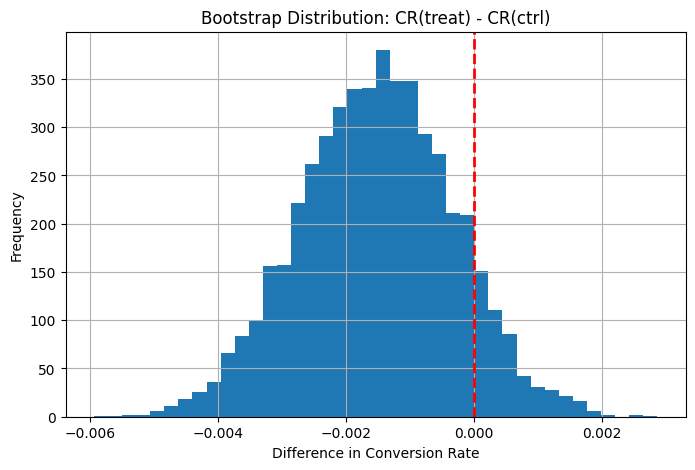

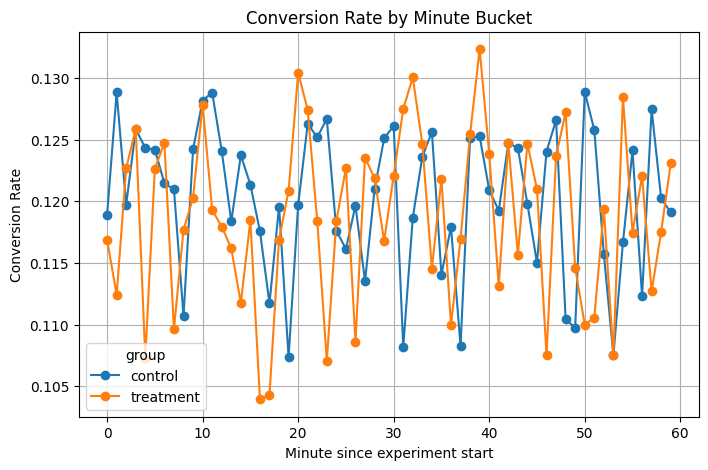


--- Country-wise Conversion Rate ---
group     control  treatment
country                     
UK       0.119621   0.121216
US       0.120570   0.118321
CA       0.118684   0.112183


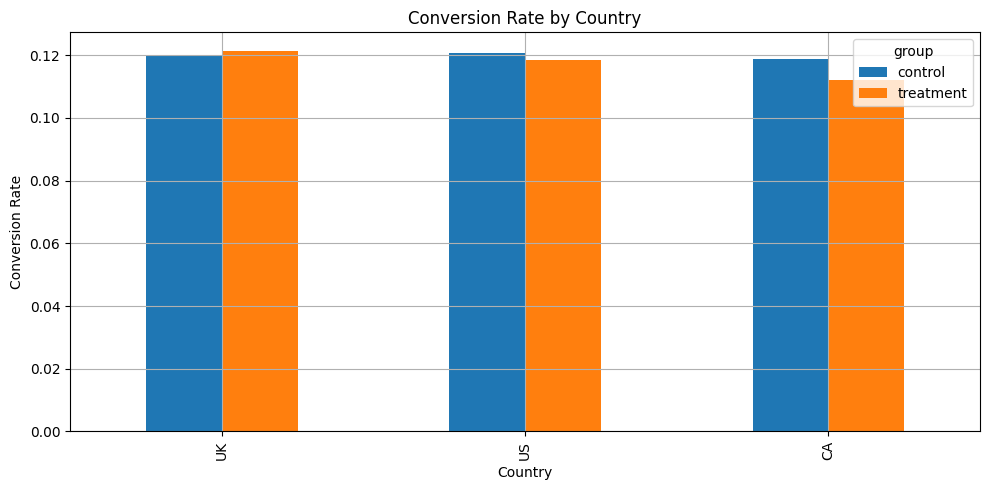


--- Logistic Regression with Country Interaction ---
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               288613
Model:                          Logit   Df Residuals:                   288607
Method:                           MLE   Df Model:                            5
Date:                Fri, 28 Nov 2025   Pseudo R-squ.:               3.430e-05
Time:                        03:49:48   Log-Likelihood:            -1.0560e+05
converged:                       True   LL-Null:                   -1.0560e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2031
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -2.0049      0.037    -54.811      0.000      -2.077      -1.933
C(country_top)[T.UK]

In [ ]:
# ============================================
# A/B Test Full Analysis with Country Breakdown
# Dataset paths:
#   - /content/ab_data.csv
#   - /content/countries.csv
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.formula.api as smf

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

AB_PATH = "/content/ab_data.csv"
COUNTRY_PATH = "/content/countries.csv"

# -----------------------------
# 1. 데이터 로드
# -----------------------------
df = pd.read_csv(AB_PATH)
print("ab_data shape:", df.shape)
countries = pd.read_csv(COUNTRY_PATH)
print("countries shape:", countries.shape)

# -----------------------------
# 2. timestamp 파싱 (분:초 형식 대응)
# -----------------------------
def looks_like_mmss(series: pd.Series) -> bool:
    s = series.astype(str)
    return s.str.match(r"^\d{1,2}:\d{2}(\.\d+)?$").mean() > 0.9

if looks_like_mmss(df["timestamp"]):
    df["elapsed"] = pd.to_timedelta("00:" + df["timestamp"].astype(str))
    df["timestamp"] = pd.Timestamp("2025-01-01") + df["elapsed"]
    df["minute_bucket"] = (df["elapsed"].dt.total_seconds() // 60).astype(int)
else:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"])

# -----------------------------
# 3. 정제(중복 제거, 불일치 제거)
# -----------------------------
df["converted"] = pd.to_numeric(df["converted"], errors="coerce").fillna(0).astype(int)
df = df.drop_duplicates()
df = df.sort_values("timestamp").drop_duplicates(subset=["user_id"], keep="first")

# 그룹–페이지 불일치 제거
mismatch = ~(
    ((df["group"] == "treatment") & (df["landing_page"] == "new_page")) |
    ((df["group"] == "control") & (df["landing_page"] == "old_page"))
)
df = df.loc[~mismatch].copy()

# -----------------------------
# 4. 국가 데이터 병합
# -----------------------------
cntry_col = None
for c in ["country", "Country", "COUNTRY"]:
    if c in countries.columns:
        cntry_col = c
        break
if cntry_col is None and countries.shape[1] >= 2:
    cntry_col = countries.columns[1]

countries = countries[["user_id", cntry_col]].rename(columns={cntry_col: "country"})
df = df.merge(countries, on="user_id", how="left")

# -----------------------------
# 5. 전체 전환율 요약
# -----------------------------
conv_ctrl = df.loc[df["group"] == "control", "converted"]
conv_treat = df.loc[df["group"] == "treatment", "converted"]

cr_ctrl = conv_ctrl.mean()
cr_treat = conv_treat.mean()
lift = (cr_treat / cr_ctrl - 1) * 100

print("\n--- Conversion Summary ---")
print(f"Control CR:   {cr_ctrl:.4%}")
print(f"Treatment CR: {cr_treat:.4%}")
print(f"Lift:         {lift:.2f}%")

# -----------------------------
# 6. Z-test
# -----------------------------
count = np.array([conv_treat.sum(), conv_ctrl.sum()])
nobs = np.array([len(conv_treat), len(conv_ctrl)])
z_stat, p_val = proportions_ztest(count, nobs)
print("\nZ-test results:")
print(f"z-stat: {z_stat:.3f}, p-value: {p_val:.5f}")

# -----------------------------
# 7. 부트스트랩 CI
# -----------------------------
rng = np.random.default_rng(42)
B = 5000
boot_diffs = []
for _ in range(B):
    s_t = rng.choice(conv_treat, size=len(conv_treat), replace=True).mean()
    s_c = rng.choice(conv_ctrl, size=len(conv_ctrl), replace=True).mean()
    boot_diffs.append(s_t - s_c)
boot_diffs = np.array(boot_diffs)

ci_boot = np.percentile(boot_diffs, [2.5, 97.5])
print(f"\nBootstrap 95% CI: ({ci_boot[0]:.4%}, {ci_boot[1]:.4%})")

plt.hist(boot_diffs, bins=40)
plt.axvline(0, color='r', linestyle='--', linewidth=2)
plt.title("Bootstrap Distribution: CR(treat) - CR(ctrl)")
plt.xlabel("Difference in Conversion Rate")
plt.ylabel("Frequency")
plt.show()

# -----------------------------
# 8. 분(minute) 단위 전환율 추세
# -----------------------------
if "minute_bucket" in df.columns:
    minute_curve = (
        df.groupby(["minute_bucket", "group"])["converted"]
          .mean().unstack().sort_index()
    )
    minute_curve.plot(marker="o")
    plt.title("Conversion Rate by Minute Bucket")
    plt.xlabel("Minute since experiment start")
    plt.ylabel("Conversion Rate")
    plt.legend(title="group")
    plt.show()

# -----------------------------
# 9. 국가별 전환율 비교
# -----------------------------
country_summary = (
    df.groupby(["country", "group"])["converted"]
      .mean().unstack()
      .sort_values("treatment", ascending=False)
)
print("\n--- Country-wise Conversion Rate ---")
print(country_summary.head(10))

# 시각화
country_summary.plot(kind="bar", figsize=(10,5))
plt.title("Conversion Rate by Country")
plt.ylabel("Conversion Rate")
plt.xlabel("Country")
plt.legend(title="group")
plt.tight_layout()
plt.show()

# -----------------------------
# 10. 국가 상호작용 로지스틱 회귀
# -----------------------------
df_lr = df.dropna(subset=["country"]).copy()
df_lr["is_treat"] = (df_lr["group"] == "treatment").astype(int)
top_countries = df_lr["country"].value_counts().head(5).index.tolist()
df_lr["country_top"] = df_lr["country"].where(df_lr["country"].isin(top_countries), "OTHER")

model = smf.logit("converted ~ is_treat * C(country_top)", data=df_lr).fit(disp=False)
print("\n--- Logistic Regression with Country Interaction ---")
print(model.summary())

# -----------------------------
# 11. 베이지안 비교
# -----------------------------
a0, b0 = 1, 1
a_t = a0 + conv_treat.sum()
b_t = b0 + (len(conv_treat) - conv_treat.sum())
a_c = a0 + conv_ctrl.sum()
b_c = b0 + (len(conv_ctrl) - conv_ctrl.sum())

S = 100000
theta_t = np.random.beta(a_t, b_t, size=S)
theta_c = np.random.beta(a_c, b_c, size=S)
diff = theta_t - theta_c
prob_t_better = (diff > 0).mean()
ci_bayes = np.percentile(diff, [2.5, 97.5])

print(f"\nBayesian: P(Treatment > Control) = {prob_t_better:.3f}")
print(f"95% credible interval = ({ci_bayes[0]:.4%}, {ci_bayes[1]:.4%})")

# -----------------------------
# 12. 요약 출력
# -----------------------------
print("\n================= SUMMARY =================")
print(f"Control CR = {cr_ctrl:.4%}")
print(f"Treatment CR = {cr_treat:.4%}")
print(f"Lift = {lift:.2f}%")
print(f"Z-test p = {p_val:.5f}")
print(f"Bootstrap 95% CI = ({ci_boot[0]:.4%}, {ci_boot[1]:.4%})")
print(f"P(Treatment > Control) = {prob_t_better:.3f}")
print("===========================================")


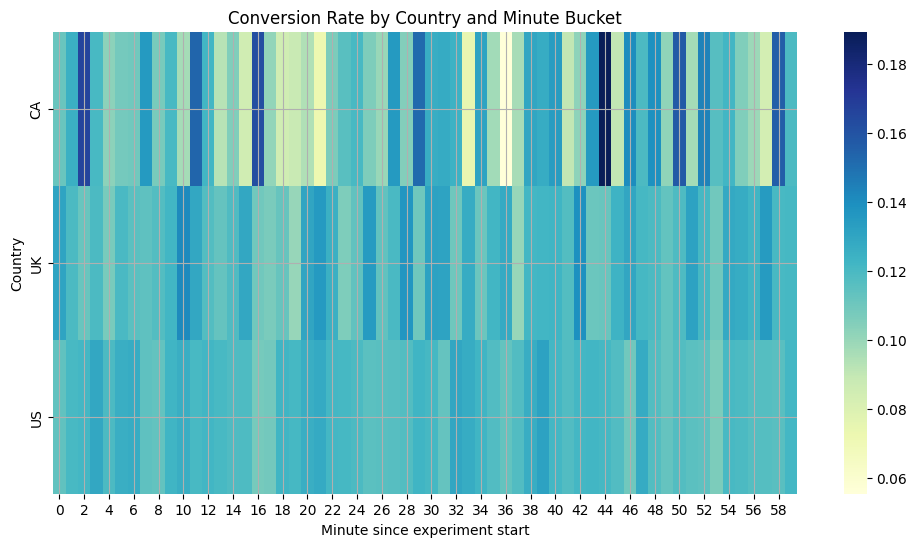

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# minute_bucket(분 단위 버킷)과 country가 있어야 함
if "minute_bucket" in df.columns and "country" in df.columns:
    # 표본이 너무 적은 국가는 제외 (예: 500 미만)
    top_countries = df["country"].value_counts().head(10).index.tolist()
    heat_df = (
        df[df["country"].isin(top_countries)]
        .groupby(["country", "minute_bucket"])["converted"]
        .mean()
        .reset_index()
    )
    pivot = heat_df.pivot(index="country", columns="minute_bucket", values="converted")

    plt.figure(figsize=(12,6))
    sns.heatmap(pivot, cmap="YlGnBu", annot=False)
    plt.title("Conversion Rate by Country and Minute Bucket")
    plt.xlabel("Minute since experiment start")
    plt.ylabel("Country")
    plt.show()


group,control,treatment,total
country,,,
US,101012,101216,202228
UK,36114,35870,71984
CA,7145,7256,14401


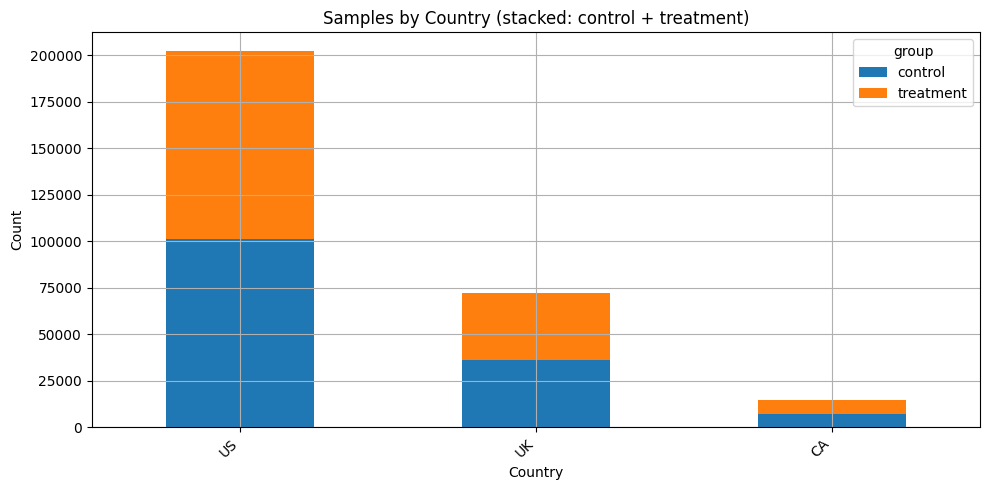

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 전제: df에 country, group, converted, minute_bucket 존재
assert {"country","group","converted"}.issubset(df.columns)

# 국가별 표본수 요약표
cnt_country_group = df.groupby(["country","group"])["converted"].count().unstack(fill_value=0)
cnt_country_group["total"] = cnt_country_group.sum(axis=1)
cnt_country_group = cnt_country_group.sort_values("total", ascending=False)
display(cnt_country_group.head(20))

# 상위 N개 국가 시각화 (전체/그룹별 스택)
TOP_N = 15
top_idx = cnt_country_group.head(TOP_N).index
plot_df = cnt_country_group.loc[top_idx, ["control","treatment"]]

ax = plot_df.plot(kind="bar", stacked=True, figsize=(10,5))
ax.set_title("Samples by Country (stacked: control + treatment)")
ax.set_xlabel("Country")
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


,country,minute_group,n,conv
0,CA,40,1216,0.130757
1,UK,55,6051,0.125269
2,US,20,16930,0.122977


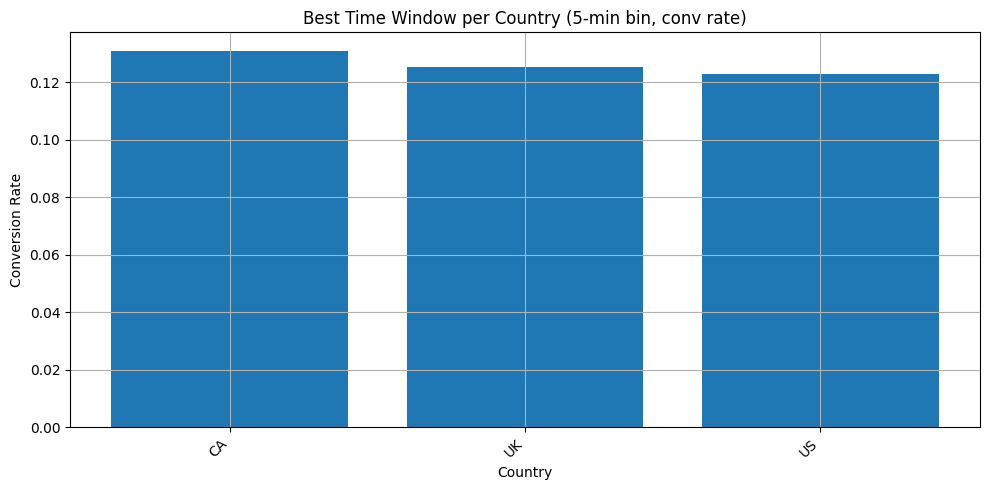

In [ ]:
# 5분 단위 버킷
if "minute_bucket" not in df.columns:
    raise ValueError("minute_bucket이 필요합니다. (분:초 형식이면 앞서 만든 코드로 생성하세요)")
df["minute_group"] = (df["minute_bucket"] // 5) * 5

# 국가×시간대 전환율과 표본수
grp = df.groupby(["country","minute_group"])
agg = grp["converted"].agg(n="count", conv="mean").reset_index()

# 각 국가에서 최소 표본수 이상인 구간만 후보로 (노이즈 제거)
MIN_N_BIN = 50
cand = agg[agg["n"] >= MIN_N_BIN].copy()

# 국가별 최고 전환 시간대 뽑기
idx = cand.groupby("country")["conv"].idxmax()
best_per_country = cand.loc[idx].sort_values("conv", ascending=False).reset_index(drop=True)

# 결과 표 (상위 20개)
display(best_per_country.head(20))  # 컬럼: country, minute_group(최고 구간 시작분), n, conv

# 상위 K개만 막대그래프
K = 15
plot_b = best_per_country.head(K).copy()
ax = plt.figure(figsize=(10,5)).gca()
ax.bar(plot_b["country"], plot_b["conv"])
ax.set_title("Best Time Window per Country (5-min bin, conv rate)")
ax.set_ylabel("Conversion Rate")
ax.set_xlabel("Country")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


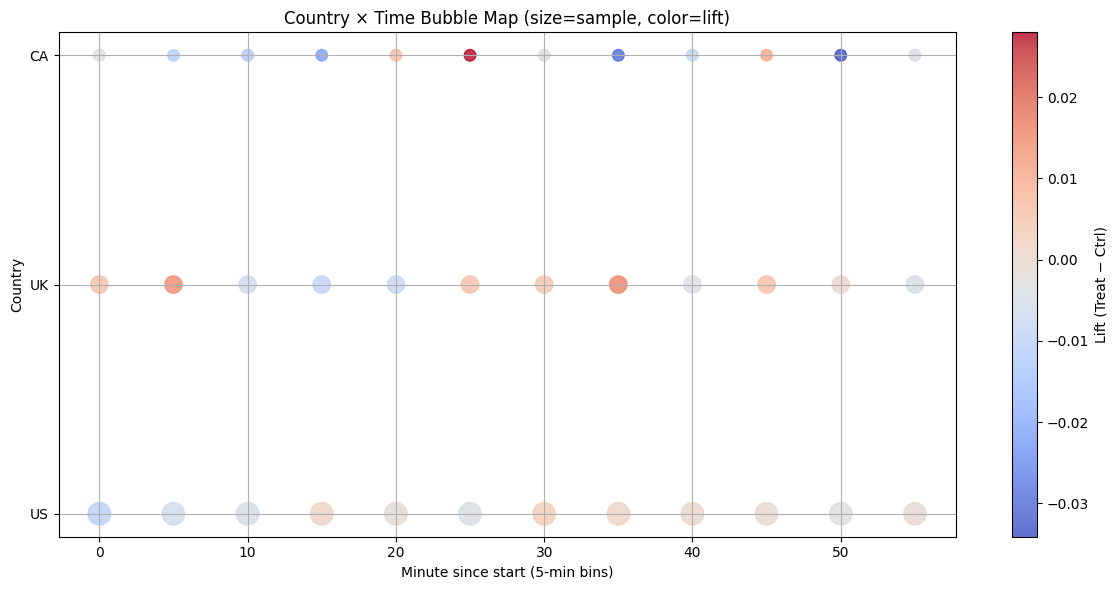

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# lift를 DataFrame으로 유지
lift = (cr_treat - cr_ctrl).to_frame(name="lift")

# 표본수도 동일한 형태로 (DataFrame)
n_total = (n_ctrl + n_treat).to_frame(name="n_total")

# 상위 국가만 선택
country_counts = n_total.groupby("country")["n_total"].sum().sort_values(ascending=False)
top_countries = country_counts.head(12).index

# 국가/시간 단위로 정리
sub = lift.loc[top_countries].reset_index()   # → country, minute_group, lift
size_df = n_total.loc[top_countries].reset_index()  # → country, minute_group, n_total

# merge로 같은 구조로 맞추기
sub = sub.merge(size_df, on=["country", "minute_group"], how="left")

# 버블 맵
plt.figure(figsize=(12,6))
countries_order = list(top_countries)
ypos = [countries_order.index(c) for c in sub["country"]]

plt.scatter(
    sub["minute_group"], ypos,
    s=np.sqrt(sub["n_total"].fillna(0))*2,       # 점 크기 = 표본수
    c=sub["lift"], cmap="coolwarm", alpha=0.8
)
plt.yticks(range(len(countries_order)), countries_order)
plt.colorbar(label="Lift (Treat − Ctrl)")
plt.title("Country × Time Bubble Map (size=sample, color=lift)")
plt.xlabel("Minute since start (5-min bins)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


=== Phase Conversion Rate Summary ===
group  control  treatment    diff
phase                            
early   0.1227     0.1182 -0.0045
late    0.1189     0.1179 -0.0010
mid     0.1196     0.1195 -0.0001


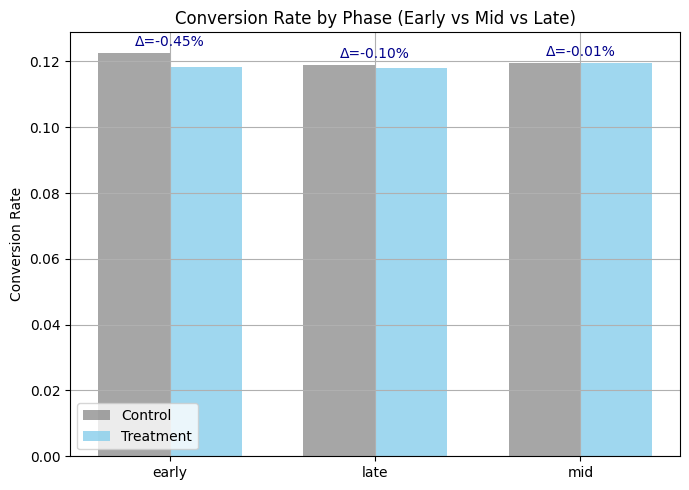

In [ ]:
# ============================================
# A/B Test - Early vs Late Phase Conversion Comparison
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ✅ 분 버킷이 없으면 timestamp로부터 생성
if "minute_bucket" not in df.columns:
    df["minute_bucket"] = (df["timestamp"] - df["timestamp"].min()).dt.total_seconds() // 60

# ✅ 실험 진행 시간대 4분위 구간 기준으로 구간 나누기
q1, q3 = df["minute_bucket"].quantile([0.25, 0.75])

df["phase"] = np.where(
    df["minute_bucket"] <= q1, "early",
    np.where(df["minute_bucket"] >= q3, "late", "mid")
)

# ✅ 구간별 group별 전환율 계산
phase_summary = (
    df.groupby(["phase", "group"])["converted"]
      .mean().unstack()
      .assign(diff=lambda x: x["treatment"] - x["control"])
      .round(4)
)
print("=== Phase Conversion Rate Summary ===")
print(phase_summary)

# ✅ 시각화
fig, ax = plt.subplots(figsize=(7,5))
x = np.arange(len(phase_summary))
width = 0.35

ax.bar(x - width/2, phase_summary["control"], width, label="Control", color="gray", alpha=0.7)
ax.bar(x + width/2, phase_summary["treatment"], width, label="Treatment", color="skyblue", alpha=0.8)

for i, val in enumerate(phase_summary["diff"]):
    ax.text(i, max(phase_summary.loc[phase_summary.index[i], ["control","treatment"]]) + 0.002,
            f"Δ={val:.2%}", ha="center", fontsize=10, color="darkblue")

ax.set_xticks(x)
ax.set_xticklabels(phase_summary.index)
ax.set_ylabel("Conversion Rate")
ax.set_title("Conversion Rate by Phase (Early vs Mid vs Late)")
ax.legend()
plt.tight_layout()
plt.show()
